<a href="https://colab.research.google.com/github/suneha113/Sectoral-Analysis-of-Expected-Credit-Loss-in-Indian-Development-Finance-2014-2024-/blob/main/creditrisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import os
import gdown
import pandas as pd

file_id = "1MVW1amhh9k3ksDsJkRo9ELvEwRplG0r2"
url = f"https://drive.google.com/uc?id={file_id}"
output = "credit_risk.csv"

if not os.path.exists(output):
    print("Downloading file...")
    gdown.download(url, output, quiet=False)
else:
    print(f"File '{output}' already exists. Skipping download.")

# Explicit column names as seen in dataset
date_cols = [
    "Agreement Signing Date",
    "Board Approval Date",
    "Closed Date (Most Recent)",
    "Effective Date (Most Recent)",
    "First Repayment Date",
    "Last Disbursement Date",
    "Last Repayment Date",
]

df = pd.read_csv(output, parse_dates=date_cols, low_memory=False)

print("\nParsed dataset shape:", df.shape)
print("Parsed date columns:", [c for c in date_cols if c in df.columns])
print(df[date_cols].head())


Downloading...
From (original): https://drive.google.com/uc?id=1MVW1amhh9k3ksDsJkRo9ELvEwRplG0r2
From (redirected): https://drive.google.com/uc?id=1MVW1amhh9k3ksDsJkRo9ELvEwRplG0r2&confirm=t&uuid=ec897f15-990e-421e-a461-a97cd256efd9
To: /content/credit_risk.csv
100%|██████████| 524M/524M [00:06<00:00, 76.2MB/s]



Parsed dataset shape: (1453381, 33)
Parsed date columns: ['Agreement Signing Date', 'Board Approval Date', 'Closed Date (Most Recent)', 'Effective Date (Most Recent)', 'First Repayment Date', 'Last Disbursement Date', 'Last Repayment Date']
  Agreement Signing Date Board Approval Date Closed Date (Most Recent)  \
0             1947-05-09          1947-05-09                1947-12-31   
1             1947-05-09          1947-05-09                1947-12-31   
2             1947-05-09          1947-05-09                1947-12-31   
3             1947-05-09          1947-05-09                1947-12-31   
4             1947-05-09          1947-05-09                1947-12-31   

  Effective Date (Most Recent) First Repayment Date Last Disbursement Date  \
0                   1947-06-09           1952-11-01                    NaT   
1                   1947-06-09           1952-11-01                    NaT   
2                   1947-06-09           1952-11-01                    NaT   
3

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453381 entries, 0 to 1453380
Data columns (total 33 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   End of Period                     1453381 non-null  object        
 1   Loan Number                       1453381 non-null  object        
 2   Region                            1453381 non-null  object        
 3   Country / Economy Code            1453020 non-null  object        
 4   Country / Economy                 1453381 non-null  object        
 5   Borrower                          1443461 non-null  object        
 6   Guarantor Country / Economy Code  1400369 non-null  object        
 7   Guarantor                         1374062 non-null  object        
 8   Loan Type                         1453381 non-null  object        
 9   Loan Status                       1453381 non-null  object        
 10  Interest Rate     

In [ ]:
df.columns = [
    col.strip().lower().replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "").replace("$", "usd").replace("'", "").replace(".", "")
    for col in df.columns
]

In [ ]:
india_df = df[df['country___economy'].str.strip() == 'India'].copy()
india_df.shape
india_df.to_csv('india_credit_risk.csv', index=False)

In [ ]:
india_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57963 entries, 3440 to 1449452
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   end_of_period                     57963 non-null  object        
 1   loan_number                       57963 non-null  object        
 2   region                            57963 non-null  object        
 3   country___economy_code            57963 non-null  object        
 4   country___economy                 57963 non-null  object        
 5   borrower                          57963 non-null  object        
 6   guarantor_country___economy_code  57821 non-null  object        
 7   guarantor                         56801 non-null  object        
 8   loan_type                         57963 non-null  object        
 9   loan_status                       57963 non-null  object        
 10  interest_rate                     57173 non-nu

In [ ]:
# 'currency_of_commitment' has all NaN
if 'currency_of_commitment' in india_df.columns:
    india_df.drop(columns=['currency_of_commitment'], inplace=True)

In [ ]:
# Convert date columns
date_cols = [
    'end_of_period',
    'first_repayment_date',
    'last_repayment_date',
    'agreement_signing_date',
    'board_approval_date',
    'effective_date_most_recent',
    'closed_date_most_recent',
    'last_disbursement_date'
]

for col in date_cols:
    if col in india_df.columns:
        india_df[col] = pd.to_datetime(india_df[col], errors='coerce')

# Add origination year
india_df["origination_year"] = india_df["agreement_signing_date"].dt.year.astype("Int64")


In [ ]:
india_df["origination_year"].unique()

<IntegerArray>
[1949, 1950, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
 1963, 1965, 1966, 1967, 1969, 1970, 1971, 1973, 1974, 1975, 1976, 1981, 1977,
 1978, 1979, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
 2005, 2006, 2007, 2008, 2009, 2010, 2011, <NA>, 2012, 2013, 2014, 2015, 2016,
 2017, 2018, 2019, 2020, 2022, 2021, 2024, 2023, 2025]
Length: 74, dtype: Int64

In [ ]:
#4. Financial columns
# -----------------------
numeric_cols = [
    'interest_rate', 'original_principal_amount_ususd', 'cancelled_amount_ususd',
    'undisbursed_amount_ususd', 'disbursed_amount_ususd', 'repaid_to_ibrd_ususd',
    'due_to_ibrd_ususd','exchange_adjustment_ususd',
    'borrowers_obligation_ususd', 'loans_held_ususd'
]

# Ensure numeric
india_df[numeric_cols] = india_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Remove negative values → set as NaN
for col in numeric_cols:
    india_df[col] = india_df[col].apply(lambda x: np.nan if x < 0 else x)


In [ ]:
# 5. Categorical cleanup
# -----------------------
for col in india_df.select_dtypes(include="object").columns:
    india_df[col] = india_df[col].astype(str).str.strip()

india_df['loan_status'] = india_df['loan_status'].astype('string').str.strip().str.upper()
print("Loan status values:", india_df['loan_status'].unique())


Loan status values: <StringArray>
[       'FULLY REPAID',              'REPAID',           'CANCELLED',
     'FULLY CANCELLED',   'FULLY TRANSFERRED',           'DISBURSED',
            'REPAYING',          'DISBURSING', 'DISBURSING&REPAYING',
     'FULLY DISBURSED',            'APPROVED',              'SIGNED',
          'TERMINATED',           'EFFECTIVE']
Length: 14, dtype: string


In [ ]:
india_df['loan_status'] = (
    india_df['loan_status']
    .astype('string')   # Pandas nullable string dtype
    .str.strip()
    .str.upper()
)

print(india_df['loan_status'].unique())


<StringArray>
[       'FULLY REPAID',              'REPAID',           'CANCELLED',
     'FULLY CANCELLED',   'FULLY TRANSFERRED',           'DISBURSED',
            'REPAYING',          'DISBURSING', 'DISBURSING&REPAYING',
     'FULLY DISBURSED',            'APPROVED',              'SIGNED',
          'TERMINATED',           'EFFECTIVE']
Length: 14, dtype: string


In [ ]:
active_statuses = [
    'REPAYING','DISBURSED','DISBURSING','DISBURSING&REPAYING',
    'FULLY DISBURSED','FULLY TRANSFERRED','APPROVED','SIGNED','EFFECTIVE'
]

india_df["is_active"] = india_df["loan_status"].isin(active_statuses).astype(int)


In [ ]:
def encode_default_balanced(status, disbursed_amount):
    if not isinstance(status, str):
        return 1  # unknown → risky by default

    status = status.strip().upper()

    #  Non-default
    if status in ["FULLY REPAID", "SIGNED", "APPROVED", "DISBURSING"]:
        return 0

    #   Default (risky or incomplete repayment)
    if status in ["REPAYING", "DISBURSED", "DISBURSING&REPAYING", "FULLY DISBURSED"]:
        return 1

    # Special case: CANCELLED
    if status in ["CANCELLED", "FULLY CANCELLED"]:
        if disbursed_amount and disbursed_amount > 0:
            return 1  # risky cancel
        else:
            return 0  # safe cancel (no money given)

    # Catch-all: treat as risky
    return 1


# Apply to dataframe
india_df["default_flag"] = india_df.apply(
    lambda row: encode_default_balanced(row["loan_status"], row["disbursed_amount_ususd"]),
    axis=1
)

print("Default flag distribution (balanced+disbursed check):")
print(india_df["default_flag"].value_counts(normalize=True) * 100)


Default flag distribution (balanced+disbursed check):
default_flag
0    57.195107
1    42.804893
Name: proportion, dtype: float64


In [ ]:
stress_df = pd.read_excel('/content/GDP+CPI DATA.xls')
stress_df.head()

,Indicator Name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,GDP growth (annual %),6.735822,6.006204,3.475733,7.288893,3.820738,5.254299,4.776564,3.965356,9.627783,...,7.996254,8.256306,6.795383,6.453851,3.871437,-5.777725,9.689592,7.609365,9.190755,6.484224
1,"Inflation, consumer prices (annual %)",11.346073,13.112547,7.890743,11.868081,8.318907,5.556424,8.729721,8.801126,9.383472,...,4.906973,4.948216,3.328173,3.938826,3.729506,6.623437,5.131407,6.699034,5.649143,4.953036


In [ ]:
# Transpose for yearly format
stress_long = stress_df.set_index("Indicator Name").T.reset_index()
stress_long.columns = ["year", "gdp_growth", "cpi_inflation"]
stress_long["year"] = stress_long["year"].astype(int)
print(stress_long.head())

   year  gdp_growth  cpi_inflation
0  1980    6.735822      11.346073
1  1981    6.006204      13.112547
2  1982    3.475733       7.890743
3  1983    7.288893      11.868081
4  1984    3.820738       8.318907


In [ ]:
# 8. Aggregate yearly credit risk
# -----------------------
india_df["year"] = india_df["agreement_signing_date"].dt.year


In [ ]:
# Merge on year
merged_df = pd.merge(india_df, stress_long, on="year", how="inner")

# 🔥 Filter  of 2014–2024
merged_df = merged_df[(merged_df["year"] >= 2014) & (merged_df["year"] <= 2024)]

print("Filtered merged dataset shape:", merged_df.shape)
print(merged_df.head(5))

Filtered merged dataset shape: (7843, 38)
      end_of_period loan_number      region country___economy_code  \
39100    2016-02-29   IBRD83010  SOUTH ASIA                     IN   
39101    2016-01-31   IBRD83010  SOUTH ASIA                     IN   
39102    2016-03-31   IBRD83010  SOUTH ASIA                     IN   
39103    2015-12-31   IBRD83010  SOUTH ASIA                     IN   
39104    2016-05-31   IBRD83010  SOUTH ASIA                     IN   

      country___economy                            borrower  \
39100             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39101             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39102             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39103             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39104             India  CONTROLLER OF AID ACCOUNTS & AUDIT   

      guarantor_country___economy_code guarantor loan_type loan_status  ...  \
39100                               IN     India       FSL  DISBURSING  ...   


In [ ]:
# Merge on year
merged_df = pd.merge(india_df, stress_long, on="year", how="inner")

# Filter for 2014–2024
merged_df = merged_df[(merged_df["year"] >= 2014) & (merged_df["year"] <= 2024)]

print("Filtered merged dataset shape:", merged_df.shape)
print(merged_df.head(5))

merged_df.to_csv('merged_df.csv', index=False)
print("Saved merged_df to merged_credit_risk.csv")

Filtered merged dataset shape: (7843, 38)
      end_of_period loan_number      region country___economy_code  \
39100    2016-02-29   IBRD83010  SOUTH ASIA                     IN   
39101    2016-01-31   IBRD83010  SOUTH ASIA                     IN   
39102    2016-03-31   IBRD83010  SOUTH ASIA                     IN   
39103    2015-12-31   IBRD83010  SOUTH ASIA                     IN   
39104    2016-05-31   IBRD83010  SOUTH ASIA                     IN   

      country___economy                            borrower  \
39100             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39101             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39102             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39103             India  CONTROLLER OF AID ACCOUNTS & AUDIT   
39104             India  CONTROLLER OF AID ACCOUNTS & AUDIT   

      guarantor_country___economy_code guarantor loan_type loan_status  ...  \
39100                               IN     India       FSL  DISBURSING  ...   


In [ ]:
merged_df.to_csv('merged_credit_risk.csv', index=False)
print("Saved merged_df to merged_credit_risk.csv")

Saved merged_df to merged_credit_risk.csv


In [ ]:
merged_df.drop(columns=[
    "region", "country___economy", "borrower", "guarantor_country___economy_code",
    "guarantor", "sold_3rd_party_ususd",
    "repaid_3rd_party_ususd", "due_3rd_party_ususd", "agreement_signing_date",
    "closed_date_most_recent", "board_approval_date", "last_disbursement_date"
], inplace=True)

In [ ]:
merged_df.shape

(7843, 26)

In [ ]:
# -----------------------
# 1. Filter dataset for 2014–2024
# -----------------------
mask = (india_df["year"] >= 2014) & (india_df["year"] <= 2024)
subset_df = india_df[mask].copy()

# -----------------------
# 2. Count loan statuses
# -----------------------
status_counts = subset_df["loan_status"].value_counts(dropna=False)
status_perc = (status_counts / status_counts.sum() * 100).round(2)

print("Loan status distribution (2014–2024):")
print(status_counts)
print("\nLoan status distribution (%) (2014–2024):")
print(status_perc)

# -----------------------
# 3. Cross-check with repayment/disbursement
# -----------------------
summary = subset_df.groupby("loan_status")[["disbursed_amount_ususd", "repaid_to_ibrd_ususd"]].agg(
    {"disbursed_amount_ususd": "mean", "repaid_to_ibrd_ususd": "mean"}
)

print("\nAverage disbursed vs repaid per status (2014–2024):")
print(summary)


Loan status distribution (2014–2024):
loan_status
DISBURSING             5530
DISBURSING&REPAYING     923
REPAYING                805
FULLY DISBURSED         380
SIGNED                  189
FULLY REPAID             14
EFFECTIVE                 2
Name: count, dtype: Int64

Loan status distribution (%) (2014–2024):
loan_status
DISBURSING             70.51
DISBURSING&REPAYING    11.77
REPAYING               10.26
FULLY DISBURSED         4.85
SIGNED                  2.41
FULLY REPAID            0.18
EFFECTIVE               0.03
Name: count, dtype: Float64

Average disbursed vs repaid per status (2014–2024):
                     disbursed_amount_ususd  repaid_to_ibrd_ususd
loan_status                                                      
DISBURSING                     8.086835e+07          1.962324e+03
DISBURSING&REPAYING            1.440874e+08          1.243887e+07
EFFECTIVE                      2.054288e+06          0.000000e+00
FULLY DISBURSED                3.792579e+08          4.5789

In [ ]:
# Count defaults (1) vs non-defaults (0)
default_counts = merged_df["default_flag"].value_counts(dropna=False)

print("Number of defaults vs non-defaults:")
print(default_counts)

# Percentage breakdown
print("\nPercentage distribution:")
print((default_counts / default_counts.sum() * 100).round(2))


Number of defaults vs non-defaults:
default_flag
0    5733
1    2110
Name: count, dtype: int64

Percentage distribution:
default_flag
0    73.1
1    26.9
Name: count, dtype: float64


In [ ]:
merged_df.columns

Index(['end_of_period', 'loan_number', 'country___economy_code', 'loan_type',
       'loan_status', 'interest_rate', 'project_id', 'project_name',
       'original_principal_amount_ususd', 'cancelled_amount_ususd',
       'undisbursed_amount_ususd', 'disbursed_amount_ususd',
       'repaid_to_ibrd_ususd', 'due_to_ibrd_ususd',
       'exchange_adjustment_ususd', 'borrowers_obligation_ususd',
       'loans_held_ususd', 'first_repayment_date', 'last_repayment_date',
       'effective_date_most_recent', 'origination_year', 'is_active',
       'default_flag', 'year', 'gdp_growth', 'cpi_inflation'],
      dtype='object')

In [ ]:
merged_df.head()

,end_of_period,loan_number,country___economy_code,loan_type,loan_status,interest_rate,project_id,project_name,original_principal_amount_ususd,cancelled_amount_ususd,...,loans_held_ususd,first_repayment_date,last_repayment_date,effective_date_most_recent,origination_year,is_active,default_flag,year,gdp_growth,cpi_inflation
39100,2016-02-29,IBRD83010,IN,FSL,DISBURSING,0.0,P121185,Natl Highways Inter-Conn,500000000.0,0.0,...,500000000.0,2019-03-15,2031-09-15,2014-08-05,2014,1,0,2014.0,7.410228,6.665657
39101,2016-01-31,IBRD83010,IN,FSL,DISBURSING,0.0,P121185,Natl Highways Inter-Conn,500000000.0,0.0,...,500000000.0,2019-03-15,2031-09-15,2014-08-05,2014,1,0,2014.0,7.410228,6.665657
39102,2016-03-31,IBRD83010,IN,FSL,DISBURSING,0.0,P121185,Natl Highways Inter-Conn,500000000.0,0.0,...,500000000.0,2019-03-15,2031-09-15,2014-08-05,2014,1,0,2014.0,7.410228,6.665657
39103,2015-12-31,IBRD83010,IN,FSL,DISBURSING,0.0,P121185,Natl Highways Inter-Conn,500000000.0,0.0,...,500000000.0,2019-03-15,2031-09-15,2014-08-05,2014,1,0,2014.0,7.410228,6.665657
39104,2016-05-31,IBRD83010,IN,FSL,DISBURSING,0.0,P121185,Natl Highways Inter-Conn,500000000.0,0.0,...,500000000.0,2019-03-15,2031-09-15,2014-08-05,2014,1,0,2014.0,7.410228,6.665657


In [ ]:

# -----------------------
# Loan-to-GDP Ratio
merged_df["loan_to_gdp_growth_ratio"] = (
    merged_df["original_principal_amount_ususd"] / (merged_df["gdp_growth"] * 1e9)
).replace([np.inf, -np.inf], np.nan).fillna(0)


merged_df["repayment_ratio"] = (
    merged_df["repaid_to_ibrd_ususd"] / merged_df["disbursed_amount_ususd"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

# -----------------------
# Check final engineered features
# -----------------------
print(merged_df[[
    "year", "default_flag", "repayment_ratio",
"loan_to_gdp_growth_ratio"
]].sample(10))


         year  default_flag  repayment_ratio  loan_to_gdp_growth_ratio
45801  2022.0             0           0.0000                  0.065709
44994  2020.0             1           0.0000                 -0.034616
45925  2021.0             0           0.0000                  0.025801
43672  2018.0             1           0.0278                  0.026682
44877  2020.0             0           0.0000                 -0.014192
41901  2017.0             0           0.0000                  0.036790
46386  2022.0             0           0.0000                  0.024969
40342  2016.0             1           0.2224                  0.181679
45215  2020.0             0           0.0000                 -0.065943
45739  2021.0             0           0.0000                  0.003303


In [ ]:
#EDA
missing_percent = merged_df.isnull().mean() * 100
missing_percent.sort_values(ascending=False)


,0
interest_rate,0.548260
effective_date_most_recent,0.242254
exchange_adjustment_ususd,0.114752
end_of_period,0.000000
loan_type,0.000000
loan_status,0.000000
project_id,0.000000
project_name,0.000000
original_principal_amount_ususd,0.000000
cancelled_amount_ususd,0.000000


<Axes: xlabel='default_flag', ylabel='count'>

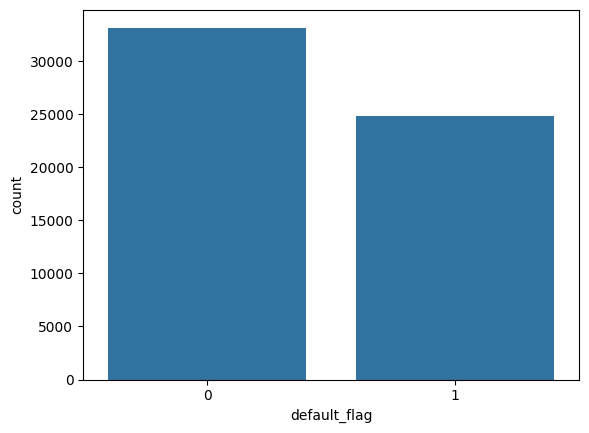

In [ ]:
merged_df['default_flag'].value_counts(normalize=True)
sns.countplot(x='default_flag', data=india_df)


In [ ]:
# All numeric financial features + engineered ones
numeric_cols = [
    'interest_rate', 'original_principal_amount_ususd', 'cancelled_amount_ususd',
    'undisbursed_amount_ususd', 'disbursed_amount_ususd', 'repaid_to_ibrd_ususd',
    'due_to_ibrd_ususd','exchange_adjustment_ususd',
    'borrowers_obligation_ususd', 'loans_held_ususd',
    "repayment_ratio", "loan_to_gdp_growth_ratio",
]

<Axes: >

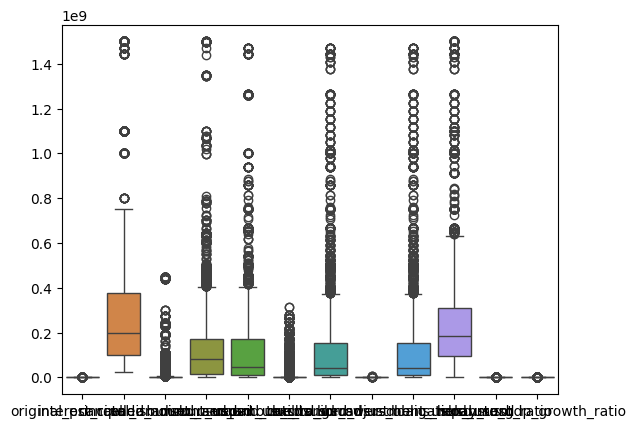

In [ ]:
sns.boxplot(data=merged_df[numeric_cols])


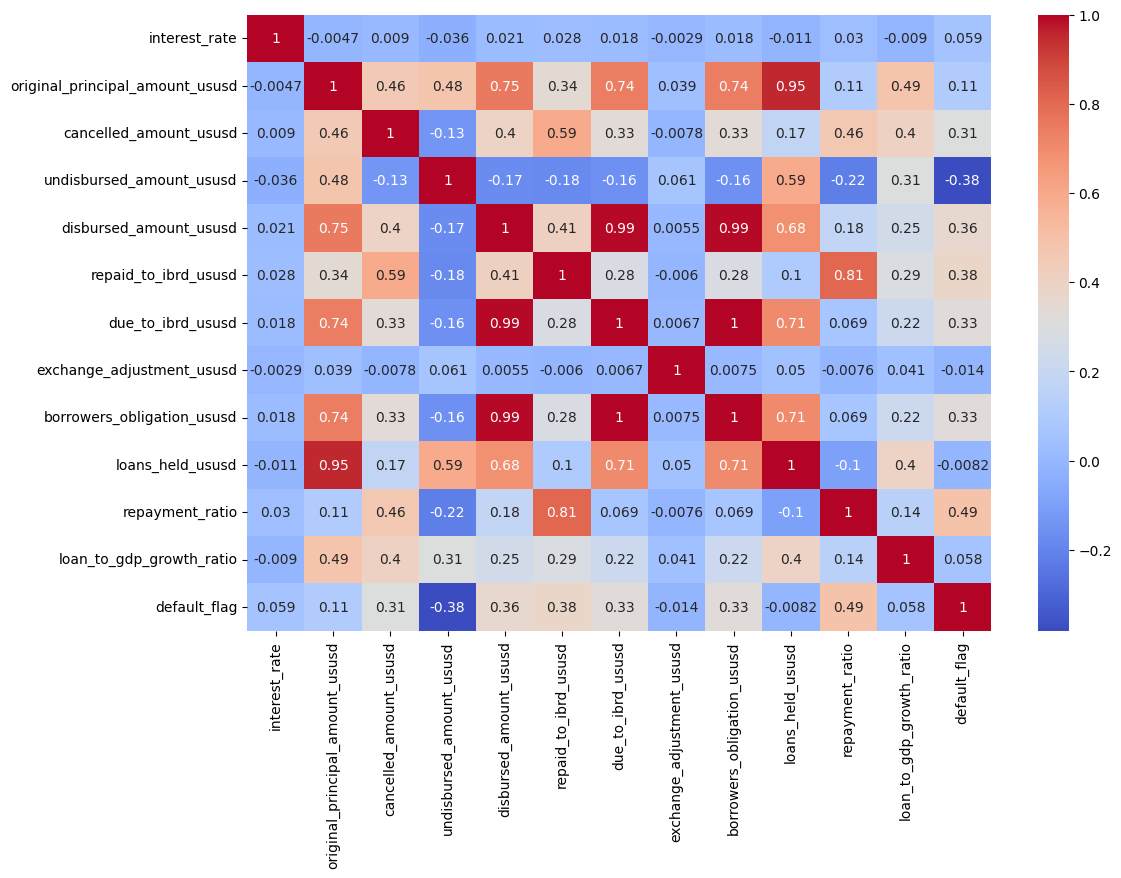

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(merged_df[numeric_cols + ['default_flag']].corr(), annot=True, cmap='coolwarm')
plt.show()


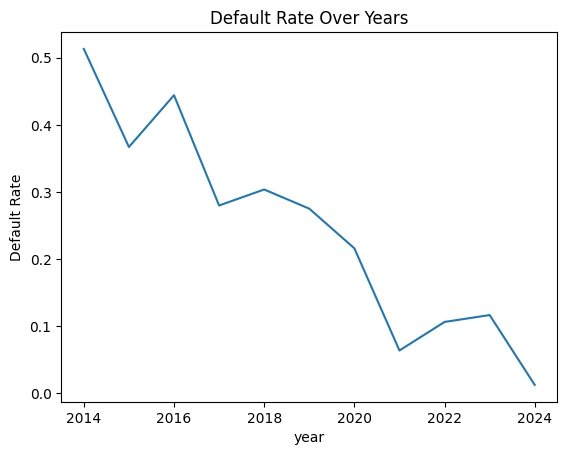

In [ ]:
default_trend = merged_df.groupby('year')['default_flag'].mean()
default_trend.plot(kind='line')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Years')
plt.show()


<Axes: xlabel='gdp_growth', ylabel='loan_to_gdp_growth_ratio'>

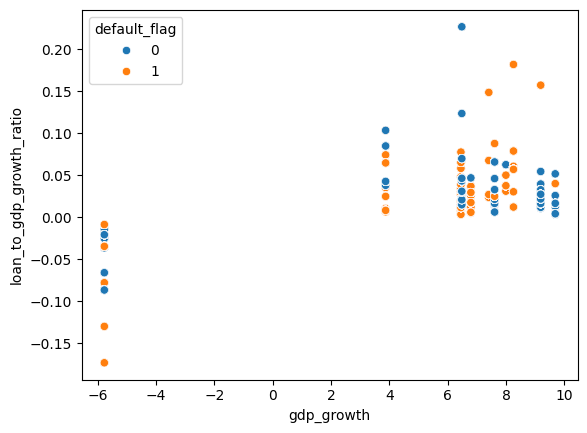

In [ ]:
sns.scatterplot(x='gdp_growth', y='loan_to_gdp_growth_ratio', hue='default_flag', data=merged_df)


<Axes: xlabel='repayment_ratio', ylabel='Count'>

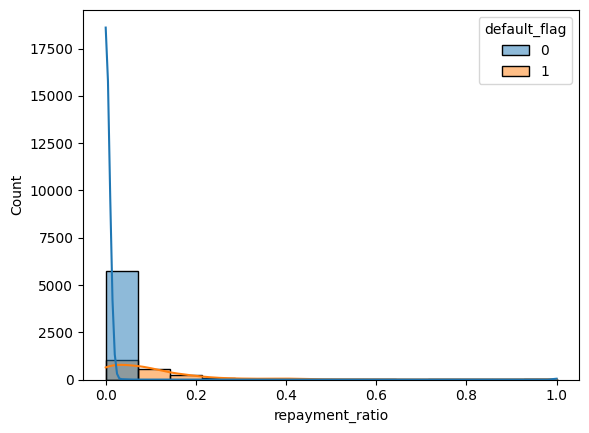

In [ ]:
sns.histplot(data=merged_df, x='repayment_ratio', hue='default_flag', kde=True)


In [ ]:


# -----------------------
# Chronological split (NO shuffle)
# Train: 2014–2020, Val: 2021–2022, Test: 2023–2024
# -----------------------
train_df = merged_df[(merged_df["year"] >= 2014) & (merged_df["year"] <= 2020)].copy()
val_df   = merged_df[(merged_df["year"] >= 2021) & (merged_df["year"] <= 2022)].copy()
test_df  = merged_df[(merged_df["year"] >= 2023) & (merged_df["year"] <= 2024)].copy()

# Extract project IDs and names from your split DataFrames
train_ids   = train_df["project_id"].values
train_names = train_df["project_name"].values

val_ids     = val_df["project_id"].values
val_names   = val_df["project_name"].values

test_ids    = test_df["project_id"].values
test_names  = test_df["project_name"].values


def show_split_info(name, df):
    if df.empty:
        print(f"{name}: EMPTY")
        return
    print(f"\n{name}: shape={df.shape}, years={int(df['year'].min())}→{int(df['year'].max())}")
    print("  class %:", (df["default_flag"].value_counts(normalize=True)*100).round(2).to_dict())

show_split_info("Train", train_df)
show_split_info("Val",   val_df)
show_split_info("Test",  test_df)



Train: shape=(6186, 28), years=2014→2020
  class %: {0: 68.07, 1: 31.93}

Val: shape=(1143, 28), years=2021→2022
  class %: {0: 91.95, 1: 8.05}

Test: shape=(514, 28), years=2023→2024
  class %: {0: 91.63, 1: 8.37}


In [ ]:
# Separate features & target
# -----------------------
X_train = train_df[numeric_cols].values
y_train = train_df["default_flag"].values

X_val   = val_df[numeric_cols].values if not val_df.empty else np.empty((0, len(numeric_cols)))
y_val   = val_df["default_flag"].values if not val_df.empty else np.array([])

X_test  = test_df[numeric_cols].values if not test_df.empty else np.empty((0, len(numeric_cols)))
y_test  = test_df["default_flag"].values if not test_df.empty else np.array([])


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed   = imputer.transform(X_val)
X_test_imputed  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled   = scaler.transform(X_val_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)


In [ ]:
print("\nScaled shapes:",
      "\n  X_train:", X_train_scaled.shape,
      "\n  X_val  :", X_val_scaled.shape,
      "\n  X_test :", X_test_scaled.shape)


Scaled shapes: 
  X_train: (6186, 12) 
  X_val  : (1143, 12) 
  X_test : (514, 12)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ------------------------
# Impute + Scale
# ------------------------
imputer = SimpleImputer(strategy="mean")

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed   = imputer.transform(X_val) if X_val.size else X_val
X_test_imputed  = imputer.transform(X_test) if X_test.size else X_test

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled   = scaler.transform(X_val_imputed) if X_val_imputed.size else X_val_imputed
X_test_scaled  = scaler.transform(X_test_imputed) if X_test_imputed.size else X_test_imputed

print("\nFinal Shapes:",
      "\n  X_train:", X_train_scaled.shape,
      "\n  X_val  :", X_val_scaled.shape,
      "\n  X_test :", X_test_scaled.shape)

# ------------------------
# Then re-run your models loop here
# ------------------------



Final Shapes: 
  X_train: (6186, 12) 
  X_val  : (1143, 12) 
  X_test : (514, 12)


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


Before Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ------------------------
# Define models with tuned hyperparameters
# ------------------------
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", solver="lbfgs", C=1.0, max_iter=2000, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=12, min_samples_split=5,
        class_weight="balanced", random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400, learning_rate=0.05, depth=6,
        verbose=0, random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=8, min_samples_split=10,
        class_weight="balanced", random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7, weights="distance"
    ),
    "SVM": SVC(
        C=1.0, kernel="rbf", probability=True,
        class_weight="balanced", random_state=42
    ),
    "Naive Bayes": GaussianNB()
}

# ------------------------
# Train & evaluate models
# ------------------------
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc])

# ------------------------
# Results table
# ------------------------
results_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)
results_df = results_df.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)

print("\nModel Comparison Table:")
print(results_df)


Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training CatBoost...
Training Decision Tree...
Training KNN...
Training SVM...
Training Naive Bayes...

Model Comparison Table:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0        Random Forest  0.959144   0.689655  0.930233  0.792079  0.970350
1    Gradient Boosting  0.955253   0.661290  0.953488  0.780952  0.969511
2        Decision Tree  0.978599   0.921053  0.813953  0.864198  0.968745
3             CatBoost  0.974708   0.968750  0.720930  0.826667  0.958056
4              XGBoost  0.974708   0.968750  0.720930  0.826667  0.948847
5                  SVM  0.879377   0.362319  0.581395  0.446429  0.907495
6  Logistic Regression  0.926070   0.560976  0.534884  0.547619  0.891893
7          Naive Bayes  0.881323   0.326923  0.395349  0.357895  0.738878
8                  KNN  0.941634   0.933333  0.325581  0.482759  0.672271


After Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# ------------------------
# Parameter grids
# ------------------------
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "saga"],
        "penalty": ["l2"]
    },
    "Random Forest": {
        "n_estimators": [200, 500, 1000],
        "max_depth": [6, 10, 15, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2"]
    },
    "Gradient Boosting": {
        "n_estimators": [200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    },
    "XGBoost": {
        "n_estimators": [200, 400, 800],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    },
    "CatBoost": {
        "iterations": [200, 400, 800],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5, 7]
    },
    "Decision Tree": {
        "max_depth": [4, 6, 8, 12],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 5, 10]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 15],
        "weights": ["uniform", "distance"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    # Naive Bayes has no major hyperparams
    "Naive Bayes": {}
}

# ------------------------
# Base models
# ------------------------
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "Naive Bayes": GaussianNB()
}

# ------------------------
# Train & evaluate with tuning
# ------------------------
results = []

for name, model in models.items():
    print(f"\nTuning {name}...")
    params = param_grids[name]

    if params:  # if there are hyperparameters to tune
        search = RandomizedSearchCV(
            model, param_distributions=params,
            n_iter=10, scoring="roc_auc", cv=3,
            random_state=42, n_jobs=-1, verbose=1
        )
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:
        # For Naive Bayes, just fit directly
        best_model = model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = best_model.predict(X_test_scaled)
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = best_model.decision_function(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc])

# ------------------------
# Results table
# ------------------------
results_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)
results_df = results_df.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)

print("\nModel Comparison Table (Tuned):")
print(results_df)



Tuning Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}

Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6}

Tuning Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for Gradient Boosting: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:42:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

Tuning CatBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 6}

Tuning Decision Tree...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4}

Tuning KNN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for KNN: {'weights': 'uniform', 'n_neighbors': 15}

Tuning SVM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Tuning Naive Bayes...

Model Comparison Table (Tuned):
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0             CatBoost  0.955253   0.661290  0.953488  0.780952  0.974596
1        Decision Tree  0.

More Tuning, CV, Check for overfitting, Confusion MATRIX & heat map for top 3 models

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------
# Dictionary to store results
# ------------------------
results = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    params = param_grids[name]

    if params:  # Hyperparameter tuning
        search = RandomizedSearchCV(
            model, param_distributions=params,
            n_iter=10, scoring="roc_auc", cv=3,
            random_state=42, n_jobs=-1, verbose=0
        )
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:  # Naive Bayes
        best_model = model.fit(X_train_scaled, y_train)

    # Train & test predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    if hasattr(best_model, "predict_proba"):
        y_train_prob = best_model.predict_proba(X_train_scaled)[:, 1]
        y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_train_prob = best_model.decision_function(X_train_scaled)
        y_test_prob = best_model.decision_function(X_test_scaled)

    # CV performance
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring="roc_auc")
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

    # Metrics
    results[name] = {
        "Train AUC": roc_auc_score(y_train, y_train_prob),
        "Test AUC": roc_auc_score(y_test, y_test_prob),
        "CV ROC-AUC Mean": cv_mean,
        "CV ROC-AUC Std": cv_std,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, zero_division=0),
        "Recall": recall_score(y_test, y_test_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_test_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_test_prob),
        "Model": best_model
    }

# ------------------------
# Results DataFrame
# ------------------------
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
results_df = results_df.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)

print("\nModel Comparison Table (with CV + Train/Test AUC):")
display(results_df[[
    "Model", "Train AUC", "Test AUC", "CV ROC-AUC Mean", "CV ROC-AUC Std",
    "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"
]])



Tuning Logistic Regression...
Best params for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}

Tuning Random Forest...
Best params for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6}

Tuning Gradient Boosting...
Best params for Gradient Boosting: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

Tuning XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:46:07] WARNING: /w


Tuning CatBoost...
Best params for CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 6}

Tuning Decision Tree...
Best params for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4}

Tuning KNN...
Best params for KNN: {'weights': 'uniform', 'n_neighbors': 15}

Tuning SVM...
Best params for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Tuning Naive Bayes...

Model Comparison Table (with CV + Train/Test AUC):


,Model,Model,Train AUC,Test AUC,CV ROC-AUC Mean,CV ROC-AUC Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,0.998384,0.974596,0.992382,0.009672,0.955253,0.66129,0.953488,0.780952,0.974596
1,Decision Tree,DecisionTreeClassifier(class_weight='balanced'...,0.998219,0.972819,0.951994,0.082102,0.978599,0.921053,0.813953,0.864198,0.972819
2,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.998651,0.972572,0.984155,0.011893,0.955253,0.66129,0.953488,0.780952,0.972572
3,Random Forest,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.99848,0.965289,0.991492,0.00743,0.959144,0.689655,0.930233,0.792079,0.965289
4,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.998376,0.947637,0.98794,0.010152,0.951362,0.673077,0.813953,0.736842,0.947637
5,SVM,"SVC(C=1, class_weight='balanced', probability=...",0.991447,0.907495,0.974594,0.030403,0.879377,0.362319,0.581395,0.446429,0.907495
6,Logistic Regression,"LogisticRegression(C=100, class_weight='balanc...",0.979531,0.893571,0.959944,0.028806,0.92607,0.560976,0.534884,0.547619,0.893571
7,KNN,KNeighborsClassifier(n_neighbors=15),0.994753,0.799906,0.91727,0.026169,0.935798,0.75,0.348837,0.47619,0.799906
8,Naive Bayes,GaussianNB(),0.927598,0.738878,0.93999,0.037523,0.881323,0.326923,0.395349,0.357895,0.738878


Confusion Matrix for the best model

Top 3 models: ['CatBoost', 'Decision Tree', 'Gradient Boosting']


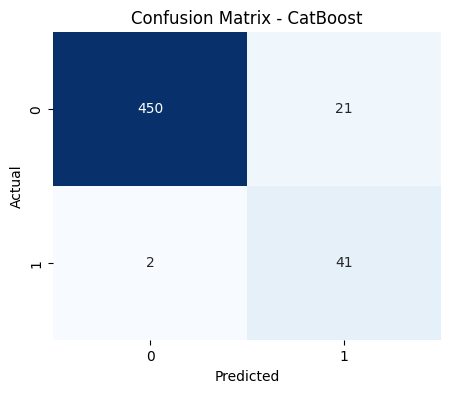

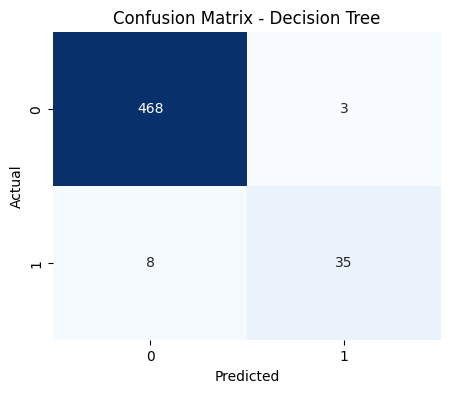

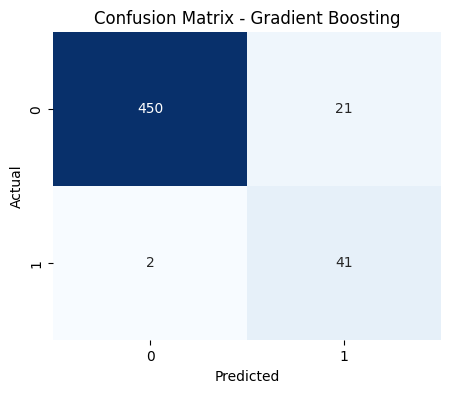

In [ ]:
# Get top 3 models by ROC-AUC
top3 = sorted(results.items(), key=lambda x: x[1]['ROC-AUC'], reverse=True)[:3]
top3_names = [x[0] for x in top3]
print("Top 3 models:", top3_names)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model_name in top3_names:
    model = results[model_name]["Model"]
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


CatBoost interpretability with SHAP

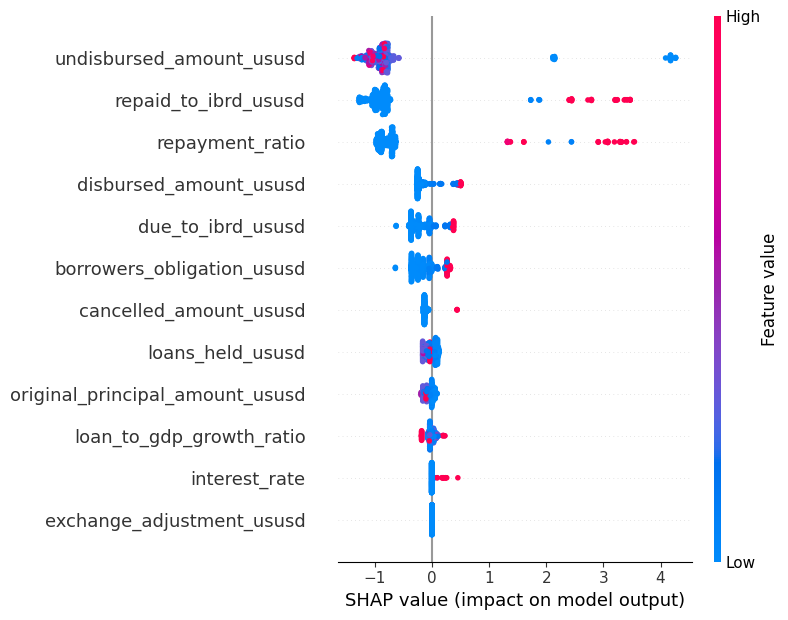

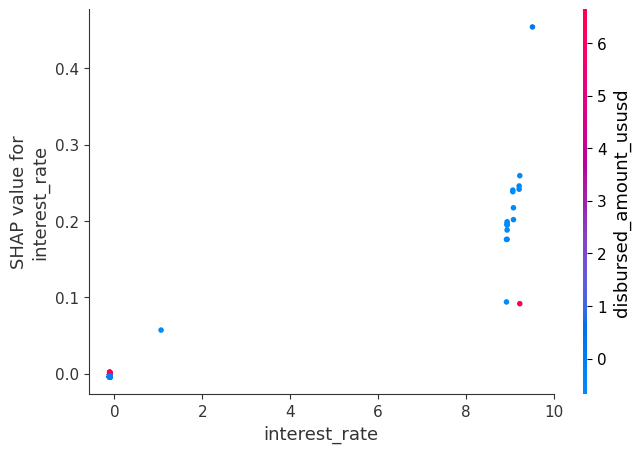

In [ ]:
# -----------------------
# Use DataFrames, not arrays
# -----------------------
X_train = train_df[numeric_cols]   # keep as DataFrame
y_train = train_df["default_flag"]

X_val   = val_df[numeric_cols]
y_val   = val_df["default_flag"]

X_test  = test_df[numeric_cols]
y_test  = test_df["default_flag"]

# -----------------------
# Impute missing values (NO scaling for CatBoost)
# -----------------------
imputer = SimpleImputer(strategy="mean")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=numeric_cols)
X_val_imputed   = pd.DataFrame(imputer.transform(X_val), columns=numeric_cols)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=numeric_cols)

# -----------------------
# Fit CatBoost properly
# -----------------------
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)

cat_model.fit(X_train_imputed, y_train)

# -----------------------
# SHAP Interpretability
# -----------------------
import shap

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test_imputed)

# Summary plot
shap.summary_plot(shap_values, X_test_imputed, feature_names=numeric_cols)

# Dependence plot for repayment_ratio
shap.dependence_plot("repayment_ratio", shap_values, X_test_imputed)


Project-level default probabilities


Top 30 projects by predicted default probability:
                                 project_name  default_prob
117  TN Sustainable Urban Development Project      0.993516
70    Meghalaya Community- Led Landscapes Mgm      0.992579
73                                      NAHEP      0.991309
119                                     TNRTP      0.981820
87      Punjab Rural Water Sector Imp Project      0.854087
24   First Programmatic Electricity Distribut      0.852261
93   Rajasthan Electric Distribution Reform 2      0.832642
103      Second Gujarat State Highway Project      0.824518
84          Program Towards Elimination of TB      0.781129
65                    MSME Emergency Response      0.762510
85                               Punjab BFAIR      0.725099
96                                    SHWSSP1      0.724328
22   First Low-Carbon Energy Programmatic DPL      0.719013
121   Tamil Nadu Housing Sector Strengthening      0.701640
51         India Responsive Social Protection    

/tmp/ipython-input-2034058292.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


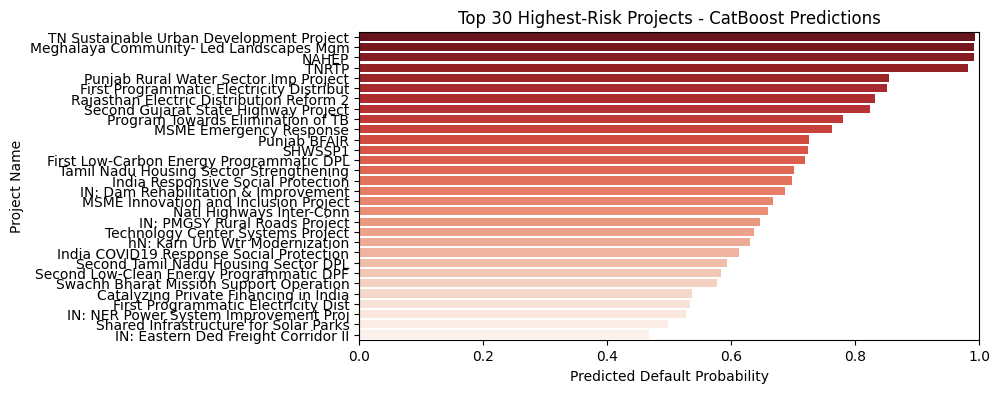

In [ ]:
# ------------------------
# Predict project-level default probability using CatBoost
# ------------------------
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np

# Get the trained CatBoost model from your results dictionary
catboost_model = results["CatBoost"]["Model"]

# Features used for prediction
X_all = merged_df[numeric_cols].values
X_all_scaled = scaler.transform(imputer.transform(X_all))  # Ensure same preprocessing

# Predict probability of default (class 1)
merged_df['default_prob'] = catboost_model.predict_proba(X_all_scaled)[:, 1]

# Aggregate probabilities per project
project_default_probs = merged_df.groupby('project_name')['default_prob'].mean().reset_index()

# Sort projects by highest default probability
project_default_probs = project_default_probs.sort_values(by='default_prob', ascending=False)

# Display top 30 highest-risk projects
print("\nTop 30 projects by predicted default probability:")
print(project_default_probs.head(30))

# Optional: barplot of top 30 projects
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(
    x='default_prob', y='project_name',
    data=project_default_probs.head(30),
    palette='Reds_r'
)
plt.xlabel("Predicted Default Probability")
plt.ylabel("Project Name")
plt.title("Top 30 Highest-Risk Projects - CatBoost Predictions")
plt.xlim(0,1)
plt.show()


In [ ]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Print the full DataFrame
print(project_default_probs)

# (Optional) Reset to default later
pd.reset_option('display.max_rows')


                                 project_name  default_prob
117  TN Sustainable Urban Development Project      0.993516
70    Meghalaya Community- Led Landscapes Mgm      0.992579
73                                      NAHEP      0.991309
119                                     TNRTP      0.981820
87      Punjab Rural Water Sector Imp Project      0.854087
24   First Programmatic Electricity Distribut      0.852261
93   Rajasthan Electric Distribution Reform 2      0.832642
103      Second Gujarat State Highway Project      0.824518
84          Program Towards Elimination of TB      0.781129
65                    MSME Emergency Response      0.762510
85                               Punjab BFAIR      0.725099
96                                    SHWSSP1      0.724328
22   First Low-Carbon Energy Programmatic DPL      0.719013
121   Tamil Nadu Housing Sector Strengthening      0.701640
51         India Responsive Social Protection      0.697991
39       IN: Dam Rehabilitation & Improv

Duplicates are there for each projcet

In [ ]:
import pandas as pd

# Count duplicates
duplicate_counts = merged_df['project_name'].value_counts()
duplicates = duplicate_counts[duplicate_counts > 1]

# Show all rows without truncation
pd.set_option('display.max_rows', None)
print(duplicates)
pd.reset_option('display.max_rows')  # Reset to default


project_name
nan                                         590
Natl Highways Inter-Conn                    116
Technology Center Systems Project           112
IN: Eastern Ded Freight Corridor II         109
Grid-Connected Rooftop Solar Program        107
IN:  TN Roads II                            104
Second Gujarat State Highway Project         89
MSME Innovation and Inclusion Project        88
GOAL                                         88
First Programmatic Electricity Distribut     87
Swachh Bharat Mission Support Operation      87
IN: NER Power System Improvement Proj        83
West Bengal ISGPP-II                         81
Assam Citizen-Centric Service Delivery       80
National Hydrology Project                   80
Madhya Pradesh Urban Development Project     80
UP Pro-Poor Tourism Development Project      79
ASPIRe Project                               79
Skill India Mission Operation                79
Odisha Higher Education Program              79
Assam Agbusiness & Rural Tr

Find the names of all the projects

In [ ]:
#find total project count (not necessary unique)
print("Total projects:", len(merged_df["project_name"].dropna()))

Total projects: 7843


All unique project names

In [ ]:
all_projects = merged_df["project_name"].dropna().unique()
print("Total projects:", len(all_projects))
print(all_projects)

Total projects: 139
['Natl Highways Inter-Conn' 'nan' 'Second Gujarat State Highway Project'
 'Second Gujarat State Highway Projec'
 'IN: Eastern Ded Freight Corridor II' 'Technology Center Systems Project'
 'MSME Innovation and Inclusion Project'
 'MSME Innovation and Inclusion Proje'
 'Punjab Rural Water Sector Imp Project'
 'IN Punjab Rural Water Sector Imprv'
 'IN Punjab Rural Water Sector Imprv Proje'
 'IN Punjab Rural Water Sector Imp Project'
 'TN Sustainable Urban Development Project'
 'TN Sustainable Urban Development Program'
 'TN Sustainable Urban Development Pr' 'IN:  TN Roads II' 'EDFC-3'
 'P150158-IN: EDFC-3' 'Swachh Bharat Mission Support Operation'
 'Swachh Bharat Mission Support Opera' 'IN: Karn Urb Wtr Modernization'
 'hN: Karn Urb Wtr Modernization'
 'First Programmatic Electricity Distribut'
 'First Programmatic Electricity Dist'
 'Grid-Connected Rooftop Solar Program'
 'Grid-Connected Rooftop Solar Progra'
 'IN: NER Power System Improvement Proj' 'West Bengal ISGPP

Making Sectors

In [ ]:
def sector(name: str) -> str:
    n = str(name).upper()

    # --- Transport & Infrastructure ---
    if any(w in n for w in ["ROAD", "HIGHWAY", "RAIL", "TRANSPORT", "LOGISTICS", "CORRIDOR", "EDFC", "MITP"]):
        return "Transport & Infrastructure"

    # --- Energy & Power ---
    if any(w in n for w in ["POWER", "ENERGY", "SOLAR", "ELECTRIC", "DISTRIBUTION", "24X7"]):
        return "Energy & Power"

    # --- Water & Irrigation ---
    if any(w in n for w in ["WATER", "IRRIGATION", "DAM", "HYDRO", "BASIN", "WASSIP", "WBADMIP", "KSWMP", "DRIP", "KARN URB WTR", "WTR",  "APIIATP", "SHWSSP" ]):
        return "Water & Irrigation"

    # --- Urban Development & Housing ---
    if any(w in n for w in ["URBAN", "CITY", "HOUSING", "MUNICIPAL", "TOURISM", "TNHHDP", "AMARAVATI", "SWACHH BHARAT"]):
        return "Urban Development & Housing"

    # --- Agriculture & Rural Development ---
    if any(w in n for w in ["AGRI", "FARM", "RURAL", "LIVELIHOOD", "DAIRY", "FISHERIES", "COOPERATIVE", "JOHAR", "POCRA", "CHIRAAG", "TNRTP", "IAMP"]):
        return "Agriculture & Rural Development"

    # --- Health & Social Protection ---
    if any(w in n for w in ["HEALTH", "RSHDP", "COVID", "NUTRITION", "DISABILITY", "HSSP", "ICDS", "TB", "SNGRBP", "PHSPP", "EHSDP", "FSPP", "RESPONSIVE SOCIAL PROTECTION"]):
        return "Health & Social Protection"

    # --- Education & Skills ---
    if any(w in n for w in ["EDUCATION", "SCHOOL", "TRAINING", "SKILL", "UNIVERSITY", "WORKFORCE", "NAHEP", "STARS", "GOAL"]):
        return "Education & Skills"

    # --- Finance & Industry ---
    if any(w in n for w in ["FINANCE", "MSME", "CREDIT", "BANK", "FISCAL", "PFM", "SAL", "DPL", "PFORR", "RAMP", "BFAIR", "PRIVATE FINANCING"]):
        return "Finance & Industry"

    # --- Governance & Policy Reform ---
    if any(w in n for w in ["ISGPP", "CAPABILITY", "GOVERNANCE", "SERVICE DELIVERY", "PSCEP", "SRESTHA", "G-ACRP", "CCP", "UCRRFP", "U-PREPARE"]):
        return "Governance & Policy Reform"

    # --- Environment & Climate ---
    if any(w in n for w in ["CLIMATE", "RESILIENT", "LANDSCAPE", "REWARD", "CHALK", "ASSIST", "SMART", "IPSS-CRRA", "AIRBMP", "TRESP"]):
        return "Environment & Climate"

    # --- Technology & Innovation ---
    if any(w in n for w in ["INNOVATE", "TECH", "ICT", "DIGITAL", "SYSTEMS", "INCLUSION", "ASPIRE", "NECTAR", "INSPIRES", "DAKSH", "KERA"]):
        return "Technology & Innovation"

    # --- Disaster Recovery & Emergency ---
    if any(w in n for w in ["DISASTER", "RECOVERY", "REHABILITATION", "RELIEF"]):
        return "Disaster Recovery & Emergency"

    return "Others"


Finding total number of projects in each sector

In [ ]:
merged_df["sector"] = merged_df["project_name"].apply(sector)
# See sector distribution
print(merged_df["sector"].value_counts())

sector
Transport & Infrastructure         1004
Water & Irrigation                  900
Health & Social Protection          810
Energy & Power                      809
Agriculture & Rural Development     755
Urban Development & Housing         740
Finance & Industry                  696
Others                              590
Education & Skills                  385
Governance & Policy Reform          379
Technology & Innovation             358
Environment & Climate               340
Disaster Recovery & Emergency        77
Name: count, dtype: int64


Average Default Probability per Sector

In [ ]:
sector_analysis = merged_df.groupby('sector').agg(
    unique_projects=('project_name', 'nunique'),       # unique projects
    total_entries=('project_name', 'count'),           # all rows
    avg_default_prob=('default_prob', 'mean')          # average default probability
).reset_index().sort_values(by='avg_default_prob', ascending=False)

print(sector_analysis)


                             sector  unique_projects  total_entries  \
3                    Energy & Power               15            809   
11      Urban Development & Housing               15            740   
9           Technology & Innovation                7            358   
10       Transport & Infrastructure               15           1004   
5                Finance & Industry               12            696   
12               Water & Irrigation               19            900   
7        Health & Social Protection               16            810   
1     Disaster Recovery & Emergency                1             77   
2                Education & Skills                6            385   
0   Agriculture & Rural Development               12            755   
6        Governance & Policy Reform               11            379   
4             Environment & Climate                9            340   
8                            Others                1            590   

    a

High-Risk Projects per Sector

In [ ]:
# Define high-risk threshold
high_risk_threshold = 0.75

# Count high-risk projects per sector (using unique project names)
high_risk_per_sector = merged_df[merged_df['default_prob'] >= high_risk_threshold] \
    .groupby('sector')['project_name'].nunique().reset_index()

high_risk_per_sector.rename(columns={'project_name': 'high_risk_projects'}, inplace=True)

# Merge with total projects and avg default probability
sector_analysis = merged_df.groupby('sector').agg(
    total_projects=('project_name', 'nunique'),
    avg_default_prob=('default_prob', 'mean')
).reset_index()

sector_analysis = sector_analysis.merge(high_risk_per_sector, on='sector', how='left')
sector_analysis['high_risk_projects'] = sector_analysis['high_risk_projects'].fillna(0).astype(int)

# Sort by avg_default_prob descending
sector_analysis = sector_analysis.sort_values(by='avg_default_prob', ascending=False)

print(sector_analysis)


                             sector  total_projects  avg_default_prob  \
3                    Energy & Power              15          0.446635   
11      Urban Development & Housing              15          0.359687   
9           Technology & Innovation               7          0.355352   
10       Transport & Infrastructure              15          0.339437   
5                Finance & Industry              12          0.308915   
12               Water & Irrigation              19          0.281017   
7        Health & Social Protection              16          0.267315   
1     Disaster Recovery & Emergency               1          0.197725   
2                Education & Skills               6          0.193852   
0   Agriculture & Rural Development              12          0.182870   
6        Governance & Policy Reform              11          0.154118   
4             Environment & Climate               9          0.090274   
8                            Others               1

Visualization: Bar Chart of Average Default Probability by Sector

/tmp/ipython-input-760234852.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


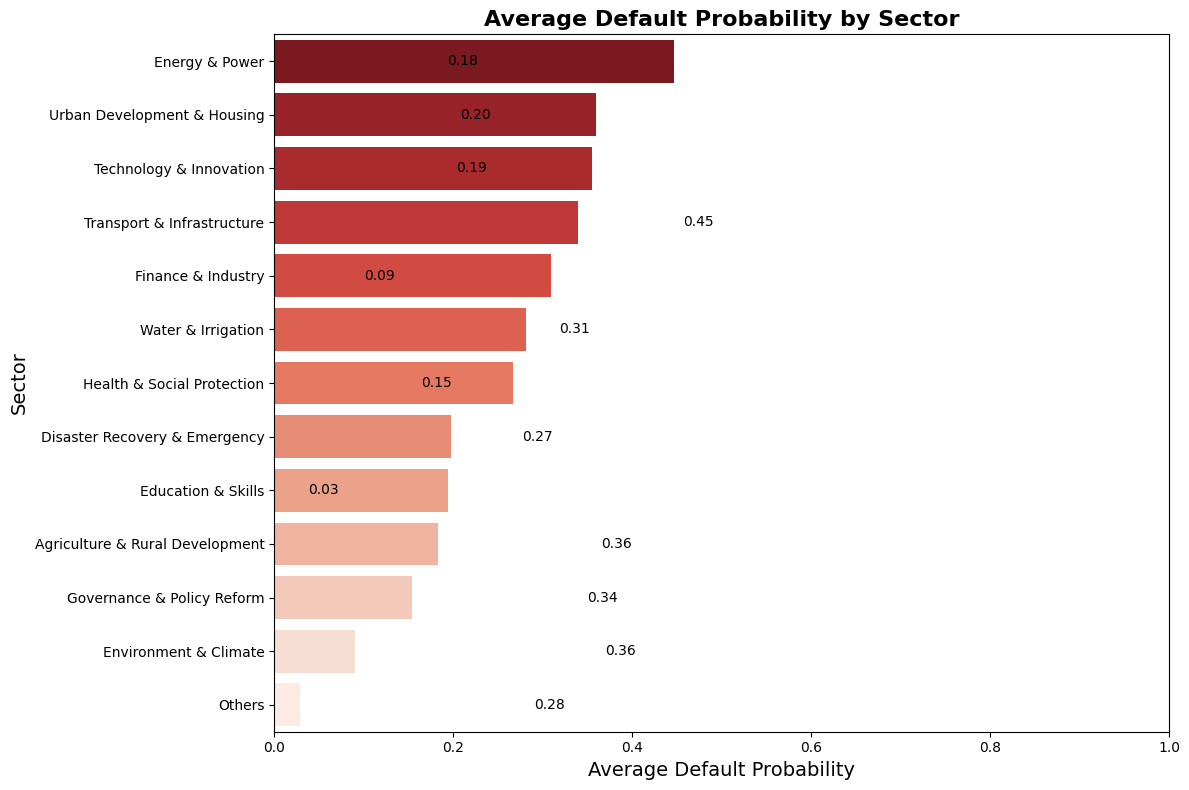

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort sectors by average default probability
sector_analysis_sorted = sector_analysis.sort_values('avg_default_prob', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(
    x='avg_default_prob',
    y='sector',
    data=sector_analysis_sorted,
    palette='Reds_r'
)

# Annotate bar values
for index, row in sector_analysis_sorted.iterrows():
    plt.text(
        row['avg_default_prob'] + 0.01,  # slightly after the bar
        index,
        f"{row['avg_default_prob']:.2f}",
        color='black',
        va='center'
    )

plt.xlim(0, 1)
plt.xlabel("Average Default Probability", fontsize=14)
plt.ylabel("Sector", fontsize=14)
plt.title("Average Default Probability by Sector", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


 Pie Chart of Project Distribution by Sector

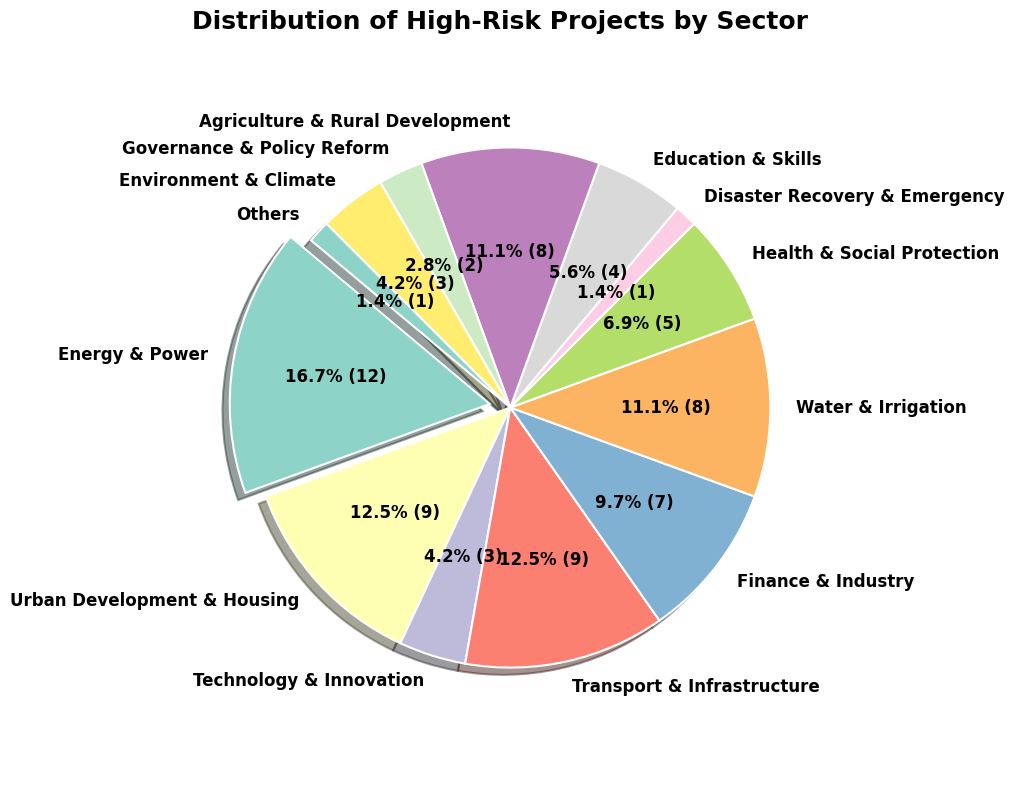

In [ ]:
import matplotlib.pyplot as plt

# Only include sectors with at least 1 high-risk project
high_risk_data = sector_analysis[sector_analysis['high_risk_projects'] > 0]

# Explode the largest slice for emphasis
explode = [0.08 if x == high_risk_data['high_risk_projects'].max() else 0 for x in high_risk_data['high_risk_projects']]

# Choose a vibrant color palette
colors = plt.cm.Set3.colors  # pastel and visually pleasing

plt.figure(figsize=(10, 8))
plt.pie(
    high_risk_data['high_risk_projects'],
    labels=high_risk_data['sector'],
    autopct=lambda p: f'{p:.1f}% ({int(p * sum(high_risk_data["high_risk_projects"]) / 100)})',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 12, 'weight': 'bold'}
)

plt.title('Distribution of High-Risk Projects by Sector', fontsize=18, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


ECL (BEFORE STRESS)

EAD(EXposure at Default)

In [ ]:
#Finding EAD(Exposure at default)
# Set conversion rate (USD to INR)
usd_to_inr = 83

In [ ]:
# Sort by project and date
merged_df = merged_df.sort_values(by=['project_name', 'end_of_period'])
# Drop rows where borrower obligation is NaN (needed for accurate EAD)
merged_df = merged_df.dropna(subset=['project_name','borrowers_obligation_ususd'])


# Find the latest date per project
latest_dates = merged_df.groupby('project_name')['end_of_period'].max().reset_index()

# Keep only loans from the latest date
latest_loans = pd.merge(
    merged_df,
    latest_dates,
    on=['project_name', 'end_of_period'],
    how='inner'
)


In [ ]:
# Weighted PD per project: sum(EAD * default_prob) / sum(EAD)
pd_weighted = latest_loans.groupby('project_name').apply(
    lambda x: pd.Series({
        'PD': (x['borrowers_obligation_ususd'] * usd_to_inr * x['default_prob']).sum() /
              (x['borrowers_obligation_ususd'] * usd_to_inr).sum()
    })
).reset_index()

# Display weighted PD per project
print(pd_weighted.head(20))


                               project_name        PD
0                                    AIRBMP  0.003580
1                                   APIIATP  0.983074
2                            ASPIRe Project  0.993823
3                           Amaravati PforR  0.003856
4         Andhra Pradesh 24X7 Power for All  0.994517
5                       Andhra Pradesh HSSP  0.058394
6                              Assam ASSIST  0.002076
7   Assam Agbusiness & Rural Transformation  0.983901
8    Assam Citizen-Centric Service Delivery  0.994319
9      Assam Inland Water Transport Project  0.978864
10            Assam Resilient Rural Bridges  0.003211
11                                      CCP  0.003981
12                                    CHALK  0.502464
13                                  CHIRAAG  0.030999
14    Catalyzing Private Financing in India  0.571506
15                Chhattisgarh PFMA Program  0.981060
16    Climate Resilient Agriculture Project  0.004930
17                          

/tmp/ipython-input-2699714213.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'PD': (x['borrowers_obligation_ususd'] * usd_to_inr * x['default_prob']).sum() /
/tmp/ipython-input-2699714213.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd_weighted = latest_loans.groupby('project_name').apply(


In [ ]:
#Takes the latest active loan of projects and if any project has 2,3 active loans it sums up their ead
ead_summary = (
    latest_loans.groupby('project_name', as_index=False)
    .agg(
        total_active_loans=('loan_number', 'count'),  # how many loans active
        EAD_INR=('borrowers_obligation_ususd', lambda x: (x.sum() * usd_to_inr))  # sum & convert to INR
    )
)

# Sort by largest exposures
ead_summary = ead_summary.sort_values('EAD_INR', ascending=False)

# Show top 20 exposures
print(ead_summary.head(20))


                                 project_name  total_active_loans  \
138                                       nan                  43   
104  Second Low-Clean Energy Programmatic DPF                   1   
22   First Low-Carbon Energy Programmatic DPL                   1   
46               India COVID-19 ERHSP Project                   1   
113   Swachh Bharat Mission Support Operation                   1   
65                    MSME Emergency Response                   1   
47                   India COVID-19 Operation                   1   
14      Catalyzing Private Financing in India                   1   
40        IN: Eastern Ded Freight Corridor II                   1   
20                                     EDFC-3                   1   
51         India Responsive Social Protection                   1   
69                          Maharashtra PoCRA                   1   
101                                     STARS                   1   
43      IN: NER Power System Impro

/tmp/ipython-input-2410306777.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ead, x='EAD_INR', y='project_name', palette='viridis')


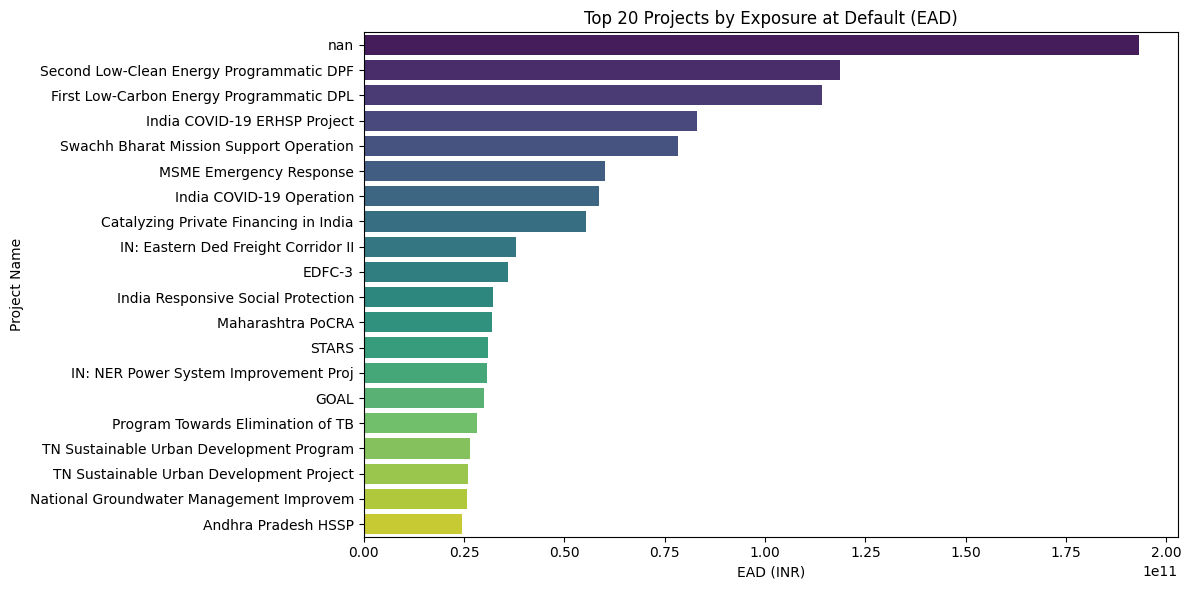

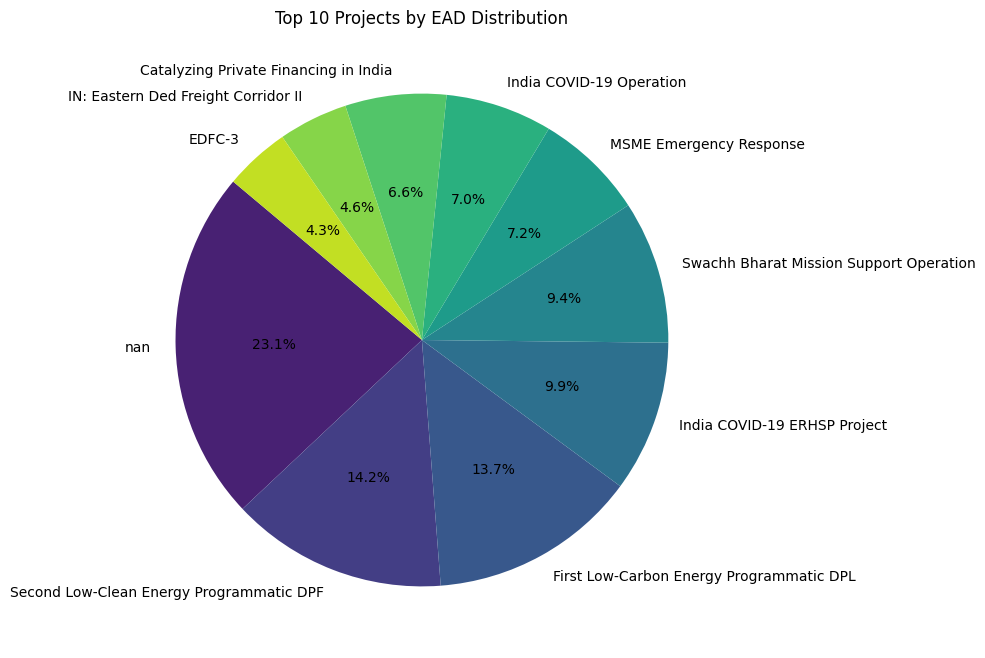

In [ ]:
#Plots
import matplotlib.pyplot as plt
import seaborn as sns


# Top 20 projects by EAD
top_ead = ead_summary.head(20)

# Bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=top_ead, x='EAD_INR', y='project_name', palette='viridis')
plt.xlabel('EAD (INR)')
plt.ylabel('Project Name')
plt.title('Top 20 Projects by Exposure at Default (EAD)')
plt.tight_layout()
plt.show()

# Pie chart for top 10 exposures
top_ead_pie = top_ead.head(10)
plt.figure(figsize=(8,8))
plt.pie(top_ead_pie['EAD_INR'], labels=top_ead_pie['project_name'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 10))
plt.title('Top 10 Projects by EAD Distribution')
plt.show()


In [ ]:
# --- Top Projects by EAD ---
top_ead_projects = ead_summary.sort_values("EAD_INR", ascending=False).head(10)
print("Top 10 Projects by Exposure at Default (EAD):")
print(top_ead_projects[['project_name', 'EAD_INR']])

Top 10 Projects by Exposure at Default (EAD):
                                 project_name       EAD_INR
138                                       nan  1.932072e+11
104  Second Low-Clean Energy Programmatic DPF  1.185946e+11
22   First Low-Carbon Energy Programmatic DPL  1.142218e+11
46               India COVID-19 ERHSP Project  8.300000e+10
113   Swachh Bharat Mission Support Operation  7.835501e+10
65                    MSME Emergency Response  6.002768e+10
47                   India COVID-19 Operation  5.854686e+10
14      Catalyzing Private Financing in India  5.536100e+10
40        IN: Eastern Ded Freight Corridor II  3.806271e+10
20                                     EDFC-3  3.594808e+10


LGD(Loss given Default)

In [ ]:
defaulted_loans = merged_df[merged_df['default_flag'] == 1]

In [ ]:
#taken the non default loans as well
# Set conversion rate
usd_to_inr = 83

# Convert USD columns to INR
merged_df['borrowers_obligation_inr'] = merged_df['borrowers_obligation_ususd'] * usd_to_inr
merged_df['repaid_to_ibrd_inr'] = merged_df['repaid_to_ibrd_ususd'] * usd_to_inr

# Calculate LGD for all loans
merged_df['LGD'] = ((merged_df['borrowers_obligation_inr'] - merged_df['repaid_to_ibrd_inr'])
                     / merged_df['borrowers_obligation_inr'])

# For performing loans (not defaulted), LGD is 0
merged_df.loc[merged_df['default_flag'] == 0, 'LGD'] = 0

# Aggregate EAD and LGD per project
lgd_all_projects = merged_df.groupby('project_name', as_index=False).apply(
    lambda x: pd.Series({
        'EAD_INR': x['borrowers_obligation_inr'].sum(),
        'LGD': ((x['borrowers_obligation_inr'] * x['LGD']).sum()) / x['borrowers_obligation_inr'].sum()
    })
).reset_index(drop=True)

# Sort by LGD or EAD if needed
lgd_all_projects = lgd_all_projects.sort_values('EAD_INR', ascending=False)

# Show output
print(lgd_all_projects[['project_name', 'EAD_INR', 'LGD']])


                                project_name       EAD_INR       LGD
113  Swachh Bharat Mission Support Operation  6.802236e+12  0.568263
46              India COVID-19 ERHSP Project  3.885229e+12  0.491348
65                   MSME Emergency Response  3.795028e+12  0.802578
40       IN: Eastern Ded Freight Corridor II  3.431316e+12  0.552905
138                                      nan  2.712920e+12  0.130026
..                                       ...           ...       ...
10             Assam Resilient Rural Bridges  8.441100e+08  0.000000
126                                   UCRRFP  7.519871e+08  0.000000
99                           SRESTHA Gujarat  2.178750e+08  0.000000
28       Grid-Connected Rooftop Solar Progra  1.037500e+08  0.000000
112      Swachh Bharat Mission Support Opera  0.000000e+00       NaN

[139 rows x 3 columns]


/tmp/ipython-input-2895433615.py:20: RuntimeWarning: invalid value encountered in scalar divide
  'LGD': ((x['borrowers_obligation_inr'] * x['LGD']).sum()) / x['borrowers_obligation_inr'].sum()
/tmp/ipython-input-2895433615.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lgd_all_projects = merged_df.groupby('project_name', as_index=False).apply(


/tmp/ipython-input-3010789867.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_lgd_all, x='LGD', y='project_name', palette='coolwarm')


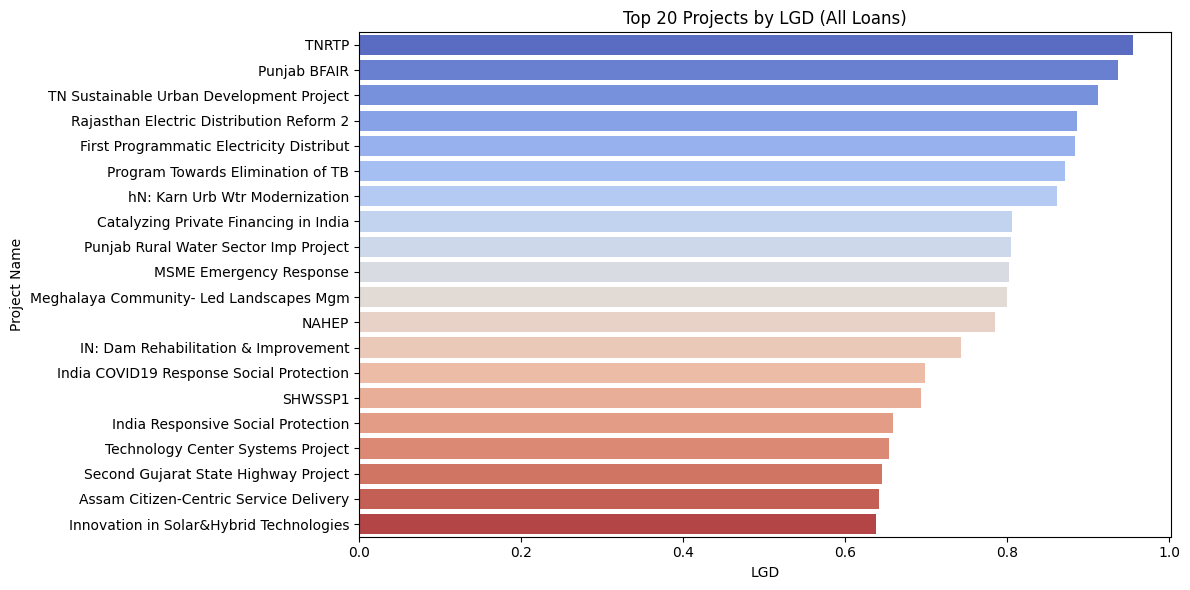

In [ ]:
# Assuming lgd_all_projects is all loans
#lgd of all projects
top_lgd_all = lgd_all_projects.sort_values('LGD', ascending=False).head(20)

# Bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=top_lgd_all, x='LGD', y='project_name', palette='coolwarm')
plt.xlabel('LGD')
plt.ylabel('Project Name')
plt.title('Top 20 Projects by LGD (All Loans)')
plt.tight_layout()
plt.show()



In [ ]:
top_lgd_projects = lgd_all_projects.sort_values("LGD", ascending=False).head(10)
print("\nTop 10 Projects by Loss Given Default (LGD):")
print(top_lgd_projects[['project_name', 'LGD']])


Top 10 Projects by Loss Given Default (LGD):
                                 project_name       LGD
119                                     TNRTP  0.954796
85                               Punjab BFAIR  0.936184
117  TN Sustainable Urban Development Project  0.912623
93   Rajasthan Electric Distribution Reform 2  0.885874
24   First Programmatic Electricity Distribut  0.883168
84          Program Towards Elimination of TB  0.871229
137            hN: Karn Urb Wtr Modernization  0.861139
14      Catalyzing Private Financing in India  0.806452
87      Punjab Rural Water Sector Imp Project  0.804674
65                    MSME Emergency Response  0.802578


In [ ]:
# --- Step 1: Prepare PD dataframe (using your variable project_default_probs) ---
pd_df = pd.DataFrame({
    "project_name": pd_weighted['project_name'],
    "PD": pd_weighted['PD']
})

# --- Step 2: Merge EAD, LGD, and PD ---
ecl_df = (ead_summary[['project_name', 'EAD_INR']]
          .merge(lgd_all_projects[['project_name', 'LGD']], on='project_name', how='left')
          .merge(pd_df, on='project_name', how='left'))

# --- Step 3: Calculate ECL ---
ecl_df['ECL_INR'] = ecl_df['EAD_INR'] * ecl_df['LGD'] * ecl_df['PD']

# --- Step 4: Sort by highest ECL ---
ecl_df = ecl_df.sort_values('ECL_INR', ascending=False)

# Show top 20
print(ecl_df[['project_name', 'EAD_INR', 'LGD', 'PD', 'ECL_INR']].head(20))


                                project_name       EAD_INR       LGD  \
2   First Low-Carbon Energy Programmatic DPL  1.142218e+11  0.630906   
5                    MSME Emergency Response  6.002768e+10  0.802578   
4    Swachh Bharat Mission Support Operation  7.835501e+10  0.568263   
3               India COVID-19 ERHSP Project  8.300000e+10  0.491348   
7      Catalyzing Private Financing in India  5.536100e+10  0.806452   
15         Program Towards Elimination of TB  2.825646e+10  0.871229   
17  TN Sustainable Urban Development Project  2.588931e+10  0.912623   
8        IN: Eastern Ded Freight Corridor II  3.806271e+10  0.552905   
13     IN: NER Power System Improvement Proj  3.066877e+10  0.616031   
9                                     EDFC-3  3.594808e+10  0.522254   
1   Second Low-Clean Energy Programmatic DPF  1.185946e+11  0.158379   
27  First Programmatic Electricity Distribut  1.806910e+10  0.883168   
10        India Responsive Social Protection  3.216250e+10  0.65

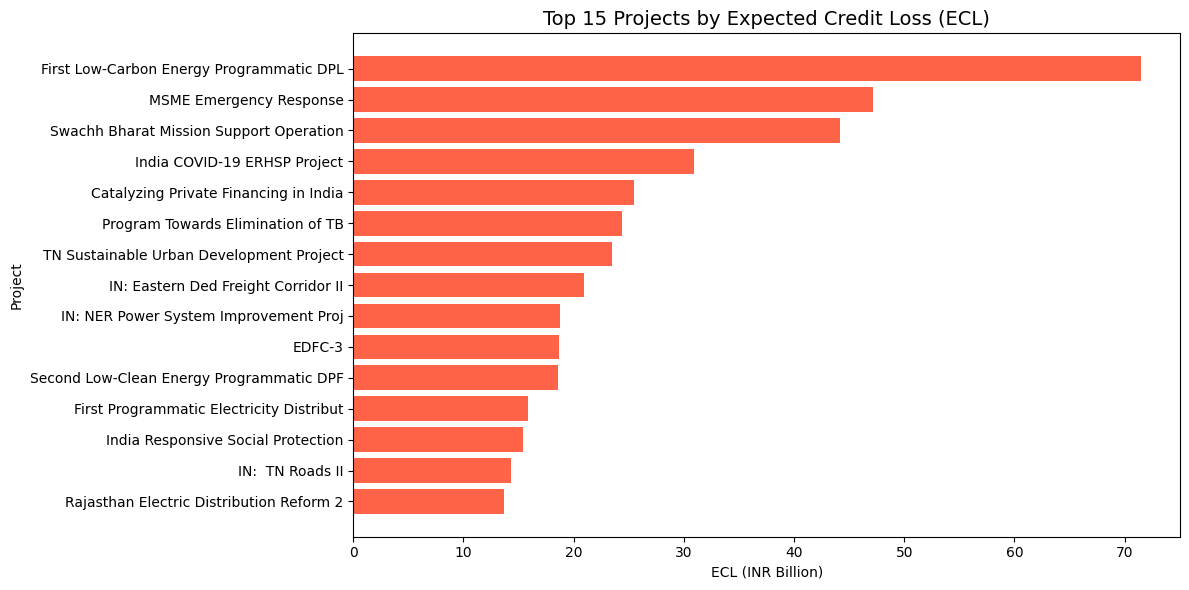

In [ ]:
import matplotlib.pyplot as plt

# Pick top 15 projects
plot_df = ecl_df.sort_values("ECL_INR", ascending=False).head(15)

plt.figure(figsize=(12,6))
plt.barh(plot_df["project_name"], plot_df["ECL_INR"]/1e9, color="tomato")  # scale to billions
plt.gca().invert_yaxis()

plt.title("Top 15 Projects by Expected Credit Loss (ECL)", fontsize=14)
plt.xlabel("ECL (INR Billion)")
plt.ylabel("Project")
plt.tight_layout()
plt.show()


In [ ]:
# Drop any old LGD, PD, EAD, or ECL columns to avoid conflicts
cols_to_drop = ['LGD', 'LGD_x', 'LGD_y', 'PD', 'EAD_INR', 'ECL_INR']
merged_df = merged_df.drop(columns=[c for c in cols_to_drop if c in merged_df.columns])

# Now merge the new columns from ecl_df
merged_df = merged_df.merge(
    ecl_df[['project_name', 'EAD_INR', 'PD', 'LGD', 'ECL_INR']],
    on='project_name',
    how='left'
)

In [ ]:
# checking ecl for any project
project = merged_df[merged_df['project_name'] == 'India COVID-19 ERHSP Project']

# Get latest values for EAD, PD, LGD
latest = project.sort_values('end_of_period').iloc[-1]

ead = latest['EAD_INR']
pd = latest['PD']
lgd = latest['LGD']

# Calculate ECL
ecl = ead * pd * lgd

print(f"EAD: {ead} Billion INR")
print(f"PD: {pd}")
print(f"LGD: {lgd}")
print(f"Calculated ECL: {ecl} Billion INR")


EAD: 83000000000.0 Billion INR
PD: 0.7586036996525575
LGD: 0.4913481128276975
Calculated ECL: 30937295185.296665 Billion INR


In [ ]:
# Make sure ecl_df has sector info
ecl_df = ecl_df.merge(
    merged_df[['project_name', 'sector']].drop_duplicates(),
    on='project_name',
    how='left'
)

In [ ]:
sector_ecl = ecl_df.groupby('sector').agg(
    total_projects=('project_name', 'nunique'),
    total_EAD_INR=('EAD_INR', 'sum'),
    avg_PD=('PD', 'mean'),
    avg_LGD=('LGD', 'mean'),
    total_ECL_INR=('ECL_INR', 'sum')  # sum ECL of all projects in the sector
).reset_index()

# Sort by highest sector-level ECL
sector_ecl = sector_ecl.sort_values('total_ECL_INR', ascending=False)

print(sector_ecl)


                             sector  total_projects  total_EAD_INR    avg_PD  \
3                    Energy & Power              15   3.802105e+11  0.767844   
7        Health & Social Protection              16   3.468066e+11  0.384944   
11      Urban Development & Housing              15   2.026064e+11  0.682472   
5                Finance & Industry              12   1.850128e+11  0.589844   
10       Transport & Infrastructure              15   2.038403e+11  0.592238   
12               Water & Irrigation              19   1.540345e+11  0.418116   
0   Agriculture & Rural Development              12   1.251939e+11  0.663463   
2                Education & Skills               6   8.959520e+10  0.664091   
6        Governance & Policy Reform              11   3.995267e+10  0.182922   
9           Technology & Innovation               7   1.771950e+10  0.427068   
4             Environment & Climate               9   2.546550e+10  0.387184   
8                            Others     

In [ ]:
# Convert sector ECL to billion INR
sector_ecl['total_ECL_BN'] = sector_ecl['total_ECL_INR'] / 1e9

# Optional: round for readability
sector_ecl['total_ECL_BN'] = sector_ecl['total_ECL_BN'].round(2)

# Display the updated table
print(sector_ecl[['sector', 'total_projects', 'total_EAD_INR', 'avg_PD', 'avg_LGD', 'total_ECL_BN']])


                             sector  total_projects  total_EAD_INR    avg_PD  \
3                    Energy & Power              15   3.802105e+11  0.767844   
7        Health & Social Protection              16   3.468066e+11  0.384944   
11      Urban Development & Housing              15   2.026064e+11  0.682472   
5                Finance & Industry              12   1.850128e+11  0.589844   
10       Transport & Infrastructure              15   2.038403e+11  0.592238   
12               Water & Irrigation              19   1.540345e+11  0.418116   
0   Agriculture & Rural Development              12   1.251939e+11  0.663463   
2                Education & Skills               6   8.959520e+10  0.664091   
6        Governance & Policy Reform              11   3.995267e+10  0.182922   
9           Technology & Innovation               7   1.771950e+10  0.427068   
4             Environment & Climate               9   2.546550e+10  0.387184   
8                            Others     

/tmp/ipython-input-3810858520.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


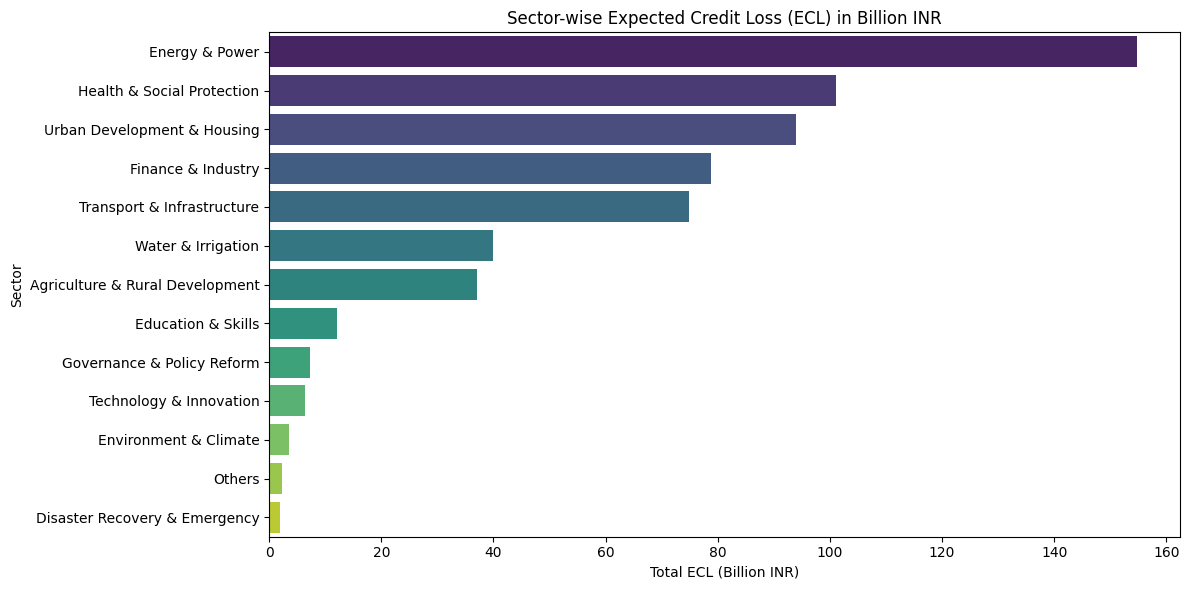

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert total ECL to billion INR
sector_ecl['total_ECL_BN'] = sector_ecl['total_ECL_INR'] / 1e9

# Optional: sort by ECL for better visualization
sector_ecl = sector_ecl.sort_values('total_ECL_BN', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=sector_ecl,
    x='total_ECL_BN',
    y='sector',
    palette='viridis'
)
plt.xlabel('Total ECL (Billion INR)')
plt.ylabel('Sector')
plt.title('Sector-wise Expected Credit Loss (ECL) in Billion INR')
plt.tight_layout()
plt.show()

Stress Testing

In [ ]:
# Only multiply if values are decimals < 1.5
for col in ['gdp_growth','cpi_inflation']:
    if merged_df[col].abs().max() <= 1.5:
        merged_df[col + '_pp'] = merged_df[col] * 100
    else:
        merged_df[col + '_pp'] = merged_df[col]  # keep as-is

In [ ]:
# Make sure macro columns exist
if 'gdp_growth' not in merged_df.columns:
    merged_df['gdp_growth'] = 0.03  # example value
if 'cpi_inflation' not in merged_df.columns:
    merged_df['cpi_inflation'] = 0.04  # example value

# Convert to percentage points
for col in ['gdp_growth','cpi_inflation']:
    if merged_df[col].abs().max() <= 1.5:
        merged_df[col + '_pp'] = merged_df[col] * 100
    else:
        merged_df[col + '_pp'] = merged_df[col]


In [ ]:
import statsmodels.api as sm

# Prepare X and y
X = merged_df[['gdp_growth_pp','cpi_inflation_pp']]
X = sm.add_constant(X)
y = merged_df['default_prob']

# Run regression
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

# Extract betas
beta_gdp = model.params['gdp_growth_pp']
beta_cpi = model.params['cpi_inflation_pp']


                            OLS Regression Results                            
Dep. Variable:           default_prob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.100
Date:                Tue, 23 Sep 2025   Prob (F-statistic):             0.0166
Time:                        08:48:05   Log-Likelihood:                -4310.1
No. Observations:                7843   AIC:                             8626.
Df Residuals:                    7840   BIC:                             8647.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2983      0.024  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make copies of baseline and stressed data
baseline_df = ecl_df.copy()     # original ECL before stress
stressed_df = baseline_df.copy()  # will store stressed PD & ECL

# --- Define stress scenario ---
delta_gdp = -3.0  # GDP shock (%)
delta_cpi = 2.0   # CPI shock (%)

# Ensure regression betas are positive
beta_gdp = abs(beta_gdp)  # from previous regression
beta_cpi = abs(beta_cpi)

# --- Calculate stressed PD ---
stressed_df["pd_stressed"] = (
    stressed_df["PD"] + beta_gdp*delta_gdp + beta_cpi*delta_cpi
)
stressed_df["pd_stressed"] = stressed_df["pd_stressed"].clip(0,1)

# Ensure LGD & EAD are defined
stressed_df['LGD'] = stressed_df['LGD'].fillna(0.45)
stressed_df['EAD_INR'] = stressed_df['EAD_INR']


In [ ]:
project_ecl = stressed_df.groupby('project_name').apply(
    lambda x: pd.Series({
        'EAD_INR': x['EAD_INR'].sum(),
        'LGD': (x['LGD']*x['EAD_INR']).sum()/x['EAD_INR'].sum(),
        'ECL_baseline': (baseline_df.loc[x.index,'EAD_INR'] * baseline_df.loc[x.index,'LGD'] * baseline_df.loc[x.index,'PD']).sum(),
        'ECL_stressed': (x['EAD_INR'] * x['LGD'] * x['pd_stressed']).sum()
    })
).reset_index()

project_ecl['Change_ECL'] = project_ecl['ECL_stressed'] - project_ecl['ECL_baseline']
project_ecl['Change_%'] = 100 * project_ecl['Change_ECL'] / project_ecl['ECL_baseline']

# --- Display top 20 projects ---
print("Project-level ECL (Baseline vs Stressed):")
print(project_ecl.sort_values('ECL_stressed', ascending=False).head(20))


Project-level ECL (Baseline vs Stressed):
                                 project_name       EAD_INR       LGD  \
22   First Low-Carbon Energy Programmatic DPL  1.142218e+11  0.630906   
65                    MSME Emergency Response  6.002768e+10  0.802578   
113   Swachh Bharat Mission Support Operation  7.835501e+10  0.568263   
46               India COVID-19 ERHSP Project  8.300000e+10  0.491348   
14      Catalyzing Private Financing in India  5.536100e+10  0.806452   
84          Program Towards Elimination of TB  2.825646e+10  0.871229   
117  TN Sustainable Urban Development Project  2.588931e+10  0.912623   
40        IN: Eastern Ded Freight Corridor II  3.806271e+10  0.552905   
43      IN: NER Power System Improvement Proj  3.066877e+10  0.616031   
104  Second Low-Clean Energy Programmatic DPF  1.185946e+11  0.158379   
20                                     EDFC-3  3.594808e+10  0.522254   
24   First Programmatic Electricity Distribut  1.806910e+10  0.883168   
51       

/tmp/ipython-input-2576274752.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'LGD': (x['LGD']*x['EAD_INR']).sum()/x['EAD_INR'].sum(),
/tmp/ipython-input-2576274752.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  project_ecl = stressed_df.groupby('project_name').apply(


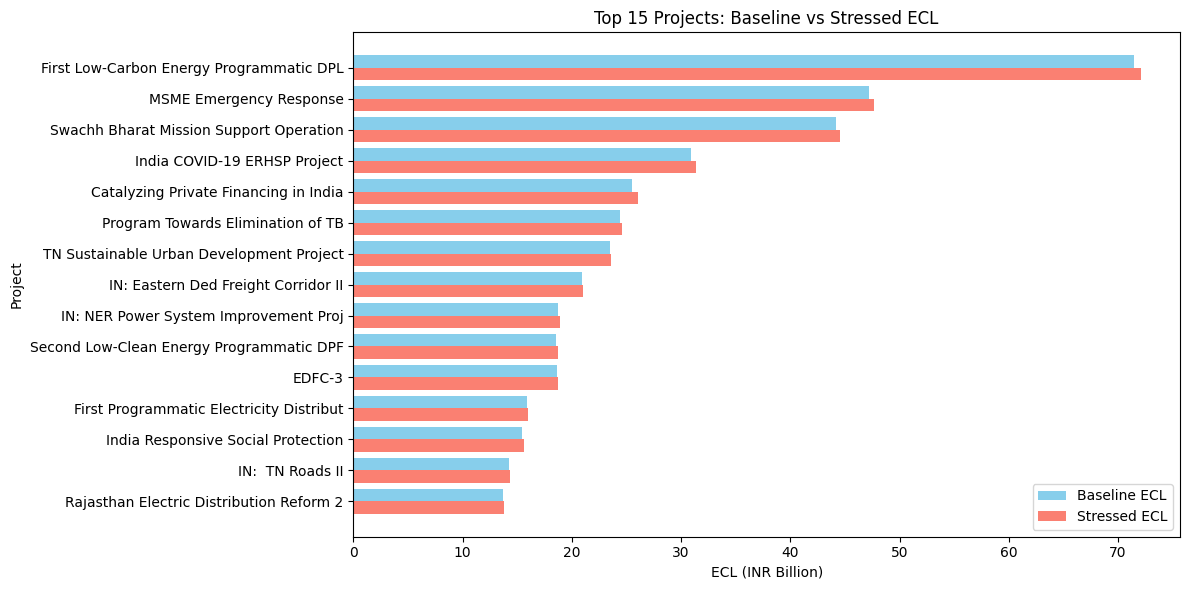

In [ ]:
top_projects = project_ecl.sort_values('ECL_stressed', ascending=False).head(15)

plt.figure(figsize=(12,6))
bar_width = 0.4
indices = np.arange(len(top_projects))

plt.barh(indices - bar_width/2, top_projects['ECL_baseline']/1e9, bar_width, label='Baseline ECL', color='skyblue')
plt.barh(indices + bar_width/2, top_projects['ECL_stressed']/1e9, bar_width, label='Stressed ECL', color='salmon')

plt.yticks(indices, top_projects['project_name'])
plt.xlabel('ECL (INR Billion)')
plt.ylabel('Project')
plt.title('Top 15 Projects: Baseline vs Stressed ECL')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
sector_ecl = stressed_df.groupby('sector').apply(
    lambda x: pd.Series({
        'total_projects': x['project_name'].nunique(),
        'ECL_baseline': (baseline_df.loc[x.index,'EAD_INR'] * baseline_df.loc[x.index,'LGD'] * baseline_df.loc[x.index,'PD']).sum(),
        'ECL_stressed': (x['EAD_INR'] * x['LGD'] * x['pd_stressed']).sum()
    })
).reset_index()

sector_ecl['Change_ECL'] = sector_ecl['ECL_stressed'] - sector_ecl['ECL_baseline']
sector_ecl['Change_%'] = 100 * sector_ecl['Change_ECL'] / sector_ecl['ECL_baseline']

# --- Display sector ECL ---
print("\nSector-level ECL (Baseline vs Stressed):")
print(sector_ecl.sort_values('ECL_stressed', ascending=False))



Sector-level ECL (Baseline vs Stressed):
                             sector  total_projects  ECL_baseline  \
3                    Energy & Power            15.0  1.547060e+11   
7        Health & Social Protection            16.0  1.010775e+11   
11      Urban Development & Housing            15.0  9.399328e+10   
5                Finance & Industry            12.0  7.878023e+10   
10       Transport & Infrastructure            15.0  7.481793e+10   
12               Water & Irrigation            19.0  3.987245e+10   
0   Agriculture & Rural Development            12.0  3.712860e+10   
2                Education & Skills             6.0  1.202615e+10   
6        Governance & Policy Reform            11.0  7.351508e+09   
9           Technology & Innovation             7.0  6.462158e+09   
4             Environment & Climate             9.0  3.469195e+09   
8                            Others             1.0  2.221207e+09   
1     Disaster Recovery & Emergency             1.0  1.978195

/tmp/ipython-input-2135478290.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_ecl = stressed_df.groupby('sector').apply(


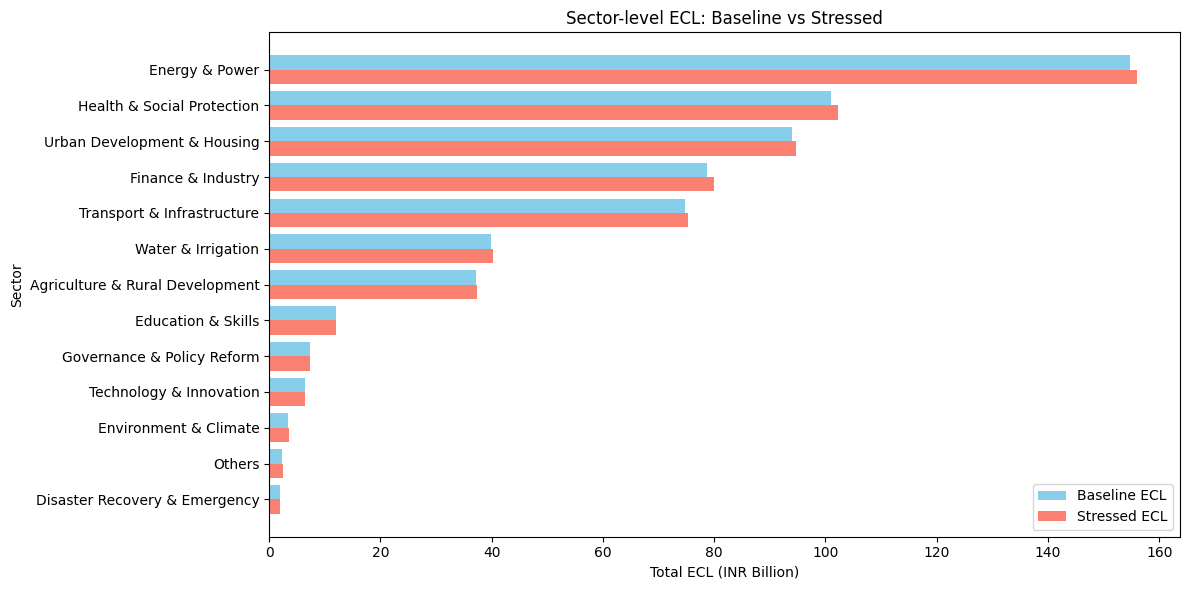

In [ ]:
sector_plot = sector_ecl.sort_values('ECL_stressed', ascending=False)
indices = np.arange(len(sector_plot))
bar_width = 0.4

plt.figure(figsize=(12,6))
plt.barh(indices - bar_width/2, sector_plot['ECL_baseline']/1e9, bar_width, label='Baseline ECL', color='skyblue')
plt.barh(indices + bar_width/2, sector_plot['ECL_stressed']/1e9, bar_width, label='Stressed ECL', color='salmon')

plt.yticks(indices, sector_plot['sector'])
plt.xlabel('Total ECL (INR Billion)')
plt.ylabel('Sector')
plt.title('Sector-level ECL: Baseline vs Stressed')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
